<div class="alert alert-info"> <b> 1. Общая информация по данным!</b></div>

In [1]:
# Импортируем необходиммые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st 
import math

In [2]:
# Загружаем и изучаем данные
data_call = pd.read_csv('/datasets/calls.csv', sep=',')
data_call['call_date'] = pd.to_datetime(data_call['call_date'], format='%Y-%m-%dT%H:%M:%S')
data_call['month'] = data_call['call_date'].dt.month
data_call.info()
display(data_call.isna().sum())

data_inte = pd.read_csv('/datasets/internet.csv', sep=',')
data_inte['session_date'] = pd.to_datetime(data_inte['session_date'], format='%Y-%m-%dT%H:%M:%S')
data_inte['month'] = data_inte['session_date'].dt.month
data_inte.info()
display(data_inte.isna().sum())

data_mess = pd.read_csv('/datasets/messages.csv', sep=',')
data_mess['message_date'] = pd.to_datetime(data_mess['message_date'], format='%Y-%m-%dT%H:%M:%S')
data_mess['month'] = data_mess['message_date'].dt.month
data_mess.info()
display(data_mess.isna().sum())

data_tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
data_tariffs = data_tariffs.rename(columns={'tariff_name': 'tariff'})
#display(data_tariffs)

data_user = pd.read_csv('/datasets/users.csv', sep=',')
data_user ['reg_date'] = pd.to_datetime(data_user ['reg_date'], format='%Y-%m-%dT%H:%M:%S')
data_user ['month'] = data_user ['reg_date'].dt.month
data_user .info()
display(data_user .isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB


id           0
call_date    0
duration     0
user_id      0
month        0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB


Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
month           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


id              0
message_date    0
user_id         0
month           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
 8   month       500 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 35.3+ KB


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
month           0
dtype: int64

<div class="alert alert-info"> <b> 2. Подготовка данных!</b></div>

In [3]:
# Проведем подсчеты для каждого пользователя
# количество сделанных звонков и израсходованных минут разговора по месяцам

data_call['duration'] = np.ceil(data_call['duration'])
data_inte['mb_used'] = np.ceil(data_inte['mb_used'])

df = data_call.groupby(['user_id', 'month']).count()
minut_sum = data_call.groupby(['user_id', 'month']).sum()
message  = data_mess.groupby(['user_id', 'month']).count()
internet = data_inte.groupby(['user_id', 'month']).count()

df['minut_sum'] = minut_sum
df['message'] = message['message_date']
df['internet_mb'] = internet['mb_used']

# Преобразуем в обычные столбцы
df.reset_index(level=0, inplace=True)
df.reset_index(level=0, inplace=True)

# удаляем лишнее
del df['duration']
del df['call_date']

# Добавляем данные из других таблиц
df = df.merge(data_user[['user_id','tariff', 'city']], on='user_id', how='outer')
df = df.merge(data_tariffs, on='tariff', how='outer')

display(df.head())
#df.info()
#display(df.isna().sum())

def proceeds_func(row):
    calls = row['minut_sum']
    internet = row['internet_mb']
    messages = row['message']
    free_calls = row['minutes_included']
    free_messages = row['messages_included']
    free_internet = row['mb_per_month_included']
    fee_calls = row['rub_per_minute']
    fee_messages = row['rub_per_message']
    fee_internet = row['rub_per_gb']
    monthly_fee = row['rub_monthly_fee']
    
    calls_proceeds = (calls - free_calls) * fee_calls + monthly_fee
    internet_proceeds = ((internet - free_internet) / 1024) * fee_internet + monthly_fee
    messages_proceeds = (messages - free_messages) * fee_messages + monthly_fee
 
    result = calls_proceeds + internet_proceeds + messages_proceeds
    if result < 0:
        result *= -1
    return result  


 
df['proceed'] = df.apply(proceeds_func, axis=1)
df.head(25)
#df.tail(5)
#df.info()

,month,user_id,id,minut_sum,message,internet_mb,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,5.0,1000,22.0,159.0,22.0,5.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,6.0,1000,43.0,172.0,60.0,49.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,7.0,1000,47.0,340.0,75.0,29.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,8.0,1000,52.0,408.0,81.0,29.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,9.0,1000,58.0,466.0,57.0,27.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1


,month,user_id,id,minut_sum,message,internet_mb,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,proceed
0,5.0,1000,22.0,159.0,22.0,5.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,2468.267578
1,6.0,1000,43.0,172.0,60.0,49.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,2410.822266
2,7.0,1000,47.0,340.0,75.0,29.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,2230.751953
3,8.0,1000,52.0,408.0,81.0,29.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,2156.751953
4,9.0,1000,58.0,466.0,57.0,27.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,2123.044922
5,10.0,1000,57.0,350.0,73.0,27.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,2223.044922
6,11.0,1000,43.0,338.0,58.0,24.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,2250.484375
7,12.0,1000,46.0,333.0,70.0,21.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,2243.923828
8,8.0,1003,55.0,380.0,37.0,15.0,ultra,Москва,1000,30720,3000,1950,150,1,1,2230.802734
9,9.0,1003,134.0,961.0,91.0,22.0,ultra,Москва,1000,30720,3000,1950,150,1,1,1594.777344


<div class="alert alert-info"> <b> 3. Анализ данных!</b></div>

In [5]:
# сгрупируем данные по месецам  
df_tariff_month_mean = df.pivot_table(index =['tariff','month'], 
                                              aggfunc = {'user_id':'count', 'minut_sum':'mean', 
                                                         'internet_mb':'mean','message':'mean',
                                                         'proceed':'mean'}).reset_index()
display(df_tariff_month_mean)
#df.describe()
#df_tariff_month.describe()
# сгрупируем данные по месецам  

df_tariff_month_var = df.pivot_table(index =['tariff','month'], 
                                              aggfunc = {'user_id':'count', 'minut_sum':'var', 
                                                         'internet_mb':'var','message':'var',
                                                         'proceed':'var'}).reset_index()
display(df_tariff_month_var)

df_tariff_month_std= df.pivot_table(index =['tariff','month'], 
                                              aggfunc = {'user_id':'count', 'minut_sum':'std', 
                                                         'internet_mb':'std','message':'std',
                                                         'proceed':'std'}).reset_index()
display(df_tariff_month_std)


,tariff,month,internet_mb,message,minut_sum,proceed,user_id
0,smart,1.0,25.617647,20.000000,203.852941,2302.902218,34
1,smart,2.0,35.465517,27.940000,298.689655,1973.858438,58
2,smart,3.0,46.909091,35.550725,390.051948,1705.179008,77
3,smart,4.0,41.803571,35.864583,367.133929,1739.318115,112
4,smart,5.0,48.340426,39.032787,387.361702,1674.462026,141
5,smart,6.0,48.478528,38.510638,398.067485,1677.511303,163
6,smart,7.0,49.079602,38.988506,408.353234,1645.421202,201
7,smart,8.0,51.334764,38.857143,423.269231,1584.901648,234
8,smart,9.0,50.436293,39.252252,430.266409,1584.969278,259
9,smart,10.0,51.604096,39.154150,427.590444,1591.936141,293


,tariff,month,internet_mb,message,minut_sum,proceed,user_id
0,smart,1.0,333.576649,252.133333,23787.341355,248220.539042,34
1,smart,2.0,337.025106,440.465714,36412.287961,375860.925967,58
2,smart,3.0,296.057416,669.780477,36823.155161,375342.993918,77
3,smart,4.0,293.096203,517.865680,34778.207127,337408.848034,112
4,smart,5.0,311.054711,638.775776,34820.061094,335807.283486,141
5,smart,6.0,263.325153,736.223100,29960.520109,290256.569215,163
6,smart,7.0,310.133632,719.352468,32250.269602,315884.021224,201
7,smart,8.0,255.740898,768.657709,34177.270551,328582.202005,234
8,smart,9.0,221.022089,705.447393,32950.529526,316496.251217,259
9,smart,10.0,297.602997,738.122969,34889.530319,336009.692795,293


,tariff,month,internet_mb,message,minut_sum,proceed,user_id
0,smart,1.0,18.264081,15.878707,154.231454,498.217361,34
1,smart,2.0,18.358244,20.987275,190.820041,613.074976,58
2,smart,3.0,17.206319,25.880117,191.893604,612.652425,77
3,smart,4.0,17.120053,22.756662,186.489161,580.869046,112
4,smart,5.0,17.636743,25.274014,186.601343,579.488812,141
5,smart,6.0,16.227297,27.133431,173.091075,538.754647,163
6,smart,7.0,17.610611,26.820747,179.583601,562.035605,201
7,smart,8.0,15.991901,27.724677,184.870956,573.220902,234
8,smart,9.0,14.866812,26.560260,181.522807,562.579995,259
9,smart,10.0,17.251174,27.168419,186.787393,579.663431,293


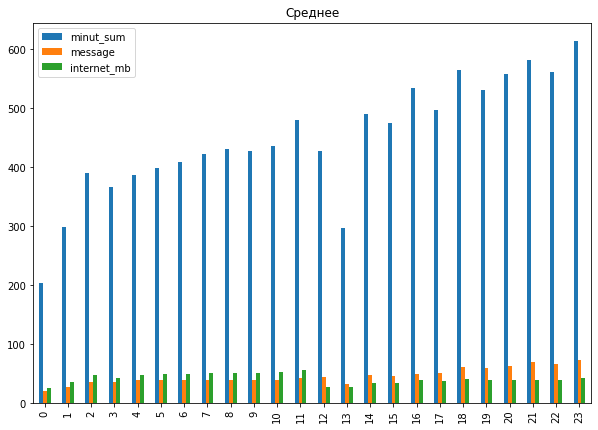

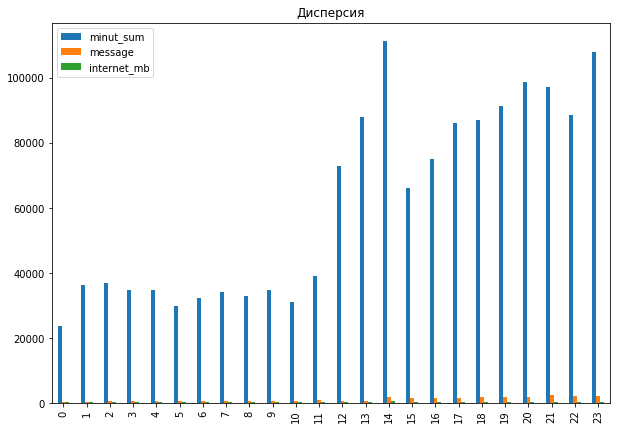

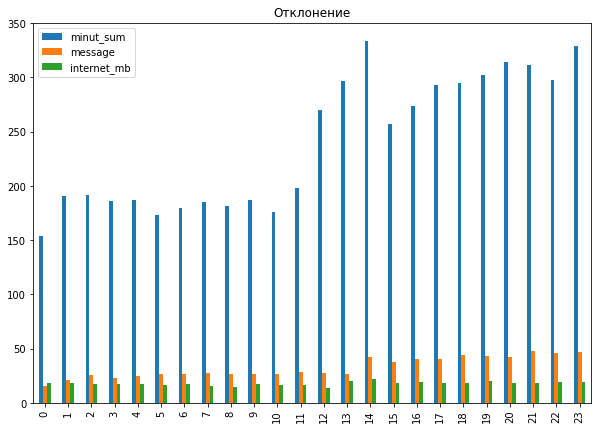

In [6]:
# Продолжить графики
df_tariff_month_mean.plot( y=['minut_sum', 'message', 'internet_mb'], 
                          figsize=(10,7), kind='bar') 
plt.title("Среднее")
plt.show()

df_tariff_month_var.plot( y=['minut_sum', 'message', 'internet_mb'], 
                          figsize=(10,7), kind='bar') 
plt.title("Дисперсия")
plt.show()

df_tariff_month_std.plot( y=['minut_sum', 'message', 'internet_mb'], 
                          figsize=(10,7), kind='bar') 
plt.title("Отклонение")
plt.show()


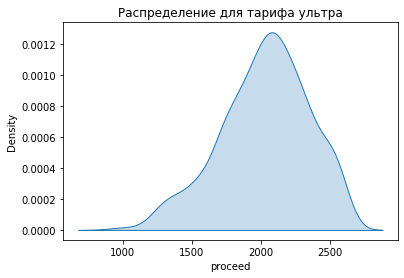

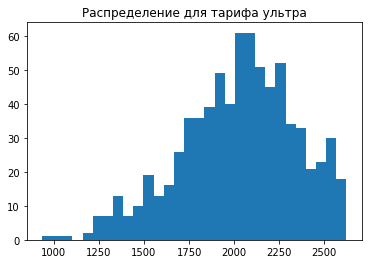

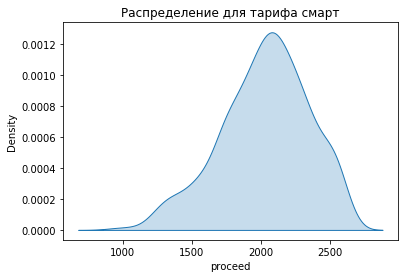

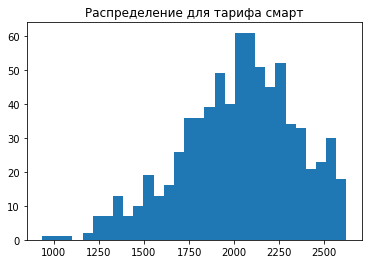

In [7]:
ultra = df[df['tariff'] == 'ultra']
mean_ultra = ultra['proceed']

smart = df[df['tariff'] == 'smart']
#smart = smart.fillna(0)
mean_smart = ultra['proceed']

snsplot = sns.kdeplot(mean_ultra, shade=True)
plt.title("Распределение для тарифа ультра")
fig = snsplot.get_figure()
plt.show()

plt.hist(mean_ultra, bins = 30)
plt.title("Распределение для тарифа ультра")
plt.show()

snsplot = sns.kdeplot(mean_smart, shade=True)
plt.title("Распределение для тарифа смарт")
fig = snsplot.get_figure()
plt.show()

plt.hist(mean_smart, bins = 30)
plt.title("Распределение для тарифа смарт")
plt.show()

# Для работы со следующим кодом
ultra = ultra.fillna(0)
mean_ultra = ultra['proceed']

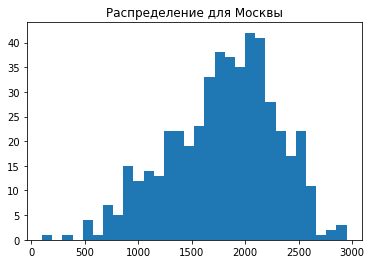

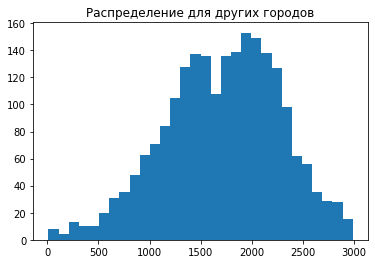

In [8]:
# Для москвы и других городов

moscow = df[df['city'] == 'Москва']
other = df[df['city'] != 'Москва']

plt.hist(moscow['proceed'], bins = 30)
plt.title("Распределение для Москвы")
plt.show()

plt.hist(other['proceed'], bins = 30)
plt.title("Распределение для других городов")
plt.show()

In [9]:
# Посмотрим дисперсии ultra и среднии
variance_ultra = np.var(mean_ultra)
print(variance_ultra, '|', np.sqrt(variance_ultra))
print(mean_ultra.describe())

# Посмотрим дисперсии smart и среднии
variance_smart = np.var(mean_smart)
print(variance_smart, '|', np.sqrt(variance_smart)) 
print(mean_smart.describe())


770952.5691467593 | 878.0390476207532
count     957.000000
mean     1591.877629
std       878.498153
min         0.000000
25%      1397.943359
50%      1939.261719
75%      2186.484375
max      2622.267578
Name: proceed, dtype: float64
101996.49618015597 | 319.3689029635728
count     752.000000
mean     2025.833631
std       319.581461
min       934.777344
25%      1822.599121
50%      2050.799805
75%      2245.288574
max      2622.267578
Name: proceed, dtype: float64


<div class="alert alert-info"> <b> 4. Проверка гипотезы!</b></div>

<div class="alert alert-info">
    <b>Строим гипотезы! </b>
    <p> Гипотеза для тарифов:</p>
    <p> H0: Тарифы смарт и ультра одинаково выгодны '='</p>
    <p> H1: Один из тарифов выгодней </p>
    <p> Гипотеза для городов:</p>
    <p> H0: Выручка в Москве и регионах одинаковая '='</p>
    <p> H1: Либо в Москве либо в регионах выручка больше </p>
</div>   

In [10]:
# cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
# Гипотеза тарифы

df_tarif = df.pivot_table(index ='tariff', 
                          aggfunc = {'user_id':'count', 'proceed':'mean'}).reset_index()

interested_value = 1591

alpha = .05 # критический уровень статистической значимости

results = st.ttest_1samp(
    mean_ultra, 
    interested_value)

print('p-значение:', results.pvalue)

if results.pvalue == alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
# средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
# Гипотиза выручка пользователей по Москве больше чем по остальным регионам
print('-----------------------------------------------------------------------')

df_city = df.pivot_table(index ='city', 
                                              aggfunc = {'user_id':'count',
                                                         'proceed':'mean'}).reset_index()
#display(df_city)

moscow = df_city[df_city['city'] == 'Москва']
other = df_city[df_city['city'] != 'Москва']
#display(moscow, other)

city = other['proceed']


#display(mean_ultra)

interested_value = 2025

alpha = .05 # критический уровень статистической значимости

results = st.ttest_1samp(
    city, 
    interested_value)

print('p-значение:', results.pvalue)

if results.pvalue == alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
# Описание в общих выводах    

p-значение: 0.9753519139250032
Не получилось отвергнуть нулевую гипотезу
-----------------------------------------------------------------------
p-значение: 1.2384075929256492e-15
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-info"> <b> 5. Выводы!</b></div>

<div class="alert alert-info"><p> Подведем итоги!</p>
<li> Первая гипотеза по тарифам была сформулирована так что таривы одинаково выгодны, однака она не подтвердилась, что говорит о том что один из тарифов более, выгодный на графиках видно, что это тариф смарт, следовательно выгодней оставить смарт, и строить новые тарифы похожими на него.</li>
<li> Вторая гипотиза была сформулирована, как в Москве и регионах средняя выручка от пользователей равна, эта гипотеза так же не подтвердилась следовательно надо искать где выгода по пользователям больше.</li>
</div>